# Install Libraries

In [1]:
!pip install -q python-gdcm
!pip install -q pylibjpeg
!pip install -q dicomsdl

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Import Libraries

In [2]:
import os,shutil, pandas as pd
from glob import glob
from tqdm import tqdm
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path

In [3]:
ROOT_PATH = '/kaggle/input/rsna-breast-cancer-detection'
IMG_DIR = '/tmp/Dataset/rsna-bcd'

# Exp. Config

In [4]:
SIZE = 300 # number dicom to process for test
NUM_SAMPLES = 10 # number of samples to show
DATA = {}

# Meta Data

In [5]:
train_df = pd.read_csv(f'{ROOT_PATH}/train.csv')
train_df['image_path'] = f'{ROOT_PATH}/train_images' + '/' + train_df.patient_id.astype(str) + '/' + train_df.image_id.astype(str) + '.dcm'
print('Train:')
print(f'# Size: {len(train_df)}')
display(train_df.head())

test_df = pd.read_csv(f'{ROOT_PATH}/test.csv')
test_df['image_path'] = f'{ROOT_PATH}/test_images' + '/' + test_df.patient_id.astype(str) + '/' + test_df.image_id.astype(str) + '.dcm'
print('Test:')
print(f'# Size: {len(test_df)}')
display(test_df.head())

Train:
# Size: 54706


site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   
3         0     NaN        0     NaN          29                    False   
4         0     0.0        0     NaN          21                     True   

                                          image_path  
0  /kaggle/input/rsna-breast-cancer-detection/tra...  
1  /kaggle/input/rsna-breast-cancer-detection/tra...  
2  /kaggle/input/rsna-breast-cancer-detection/tra...  
3  /kaggle/input/rsna-breast-cancer-detection/tra...  
4  /kaggle/input/rsna-breast-cancer-detection/tra...

Test:
# Size: 4


site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   
2        2       10008    68070693          R  MLO   81        0          21   
3        2       10008   361203119          R   CC   81        0          21   

  prediction_id                                         image_path  
0       10008_L  /kaggle/input/rsna-breast-cancer-detection/tes...  
1       10008_L  /kaggle/input/rsna-breast-cancer-detection/tes...  
2       10008_R  /kaggle/input/rsna-breast-cancer-detection/tes...  
3       10008_R  /kaggle/input/rsna-breast-cancer-detection/tes...

# Filepaths

In [6]:
file_paths = train_df.groupby(['patient_id']).sample(1).image_path[:SIZE].tolist()

# `.dcm` to `.png`

In [7]:
!rm -r {IMG_DIR}
os.makedirs(f'{IMG_DIR}/train_images', exist_ok = True)
os.makedirs(f'{IMG_DIR}/test_images', exist_ok = True)

rm: cannot remove '/tmp/Dataset/rsna-bcd': No such file or directory


# Utils

In [8]:
import dicomsdl
import cv2
import time
from scipy import stats

def read_img(path):
    return cv2.imread(path)

def read_xray(path, fix_monochrome = True):
    dicom = dicomsdl.open(path)
    h0, w0 = dicom.Rows, dicom.Columns
    data = dicom.pixelData(storedvalue=False)  # storedvalue = True for int16 return otherwise float32
    data = data - np.min(data)
    data = data / np.max(data)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    data = (data * 255).astype(np.uint8)
    return data, h0, w0

def get_img2roi(roi_fn, roi_algo):
    def img2roi(file_path):
        # read dicom
        img, h0, w0 = read_xray(file_path)

        # extract roi
        img = roi_fn(img)
        
        # get new size
        h, w = img.shape[:2]

        # process path
        sub_path = file_path.split("/",4)[-1].split('.dcm')[0] + '.png'
        infos = sub_path.split('/')
        pid = infos[-2]
        iid = infos[-1]; iid = iid.replace('.png','')
        new_path = os.path.join(IMG_DIR, roi_algo, f'{pid}_{iid}.png')
        os.makedirs(new_path.rsplit('/',1)[0], exist_ok=True)

        # save img
        cv2.imwrite(new_path, img)
        return new_path, h, w, h0, w0
    return img2roi

def check(roi_fn, roi_algo):
    img2roi = get_img2roi(roi_fn, roi_algo)
    
    tick = time.time()
    infos = [img2roi(file_path) for file_path in tqdm(file_paths, leave=True, position=0)]
    tock = time.time()
    
    new_path, h, w, h0, w0 = list(zip(*infos))
    df = pd.DataFrame({'image_path':new_path,
                           'width':w,
                           'height':h,
                           'width0':w0,
                           'height0':h0})
    
    duration = (tock - tick)
    return df, duration

def plot_size(df, name):
    plt.figure(figsize=(8,6))
    
    res0 = stats.linregress(df.width0, df.height0)
    plt.plot(df.width0, df.height0, 'bo')
    plt.plot(df.width0, res0.intercept + res0.slope*df.width0, '-.b',)
    
    res = stats.linregress(df.width, df.height)
    plt.plot(df.width, df.height, 'ro')
    plt.plot(df.width, res.intercept + res.slope*df.width, '-.r',)
    
    plt.xlabel('Width', fontsize=12)
    plt.ylabel('Height', fontsize=12)
    plt.title(f"Original Vs {name}-ROI\nR = (H/W) = {res.slope:0.3f}", fontsize=13)
    plt.legend(['original',
                'original fitted',
                f'{name}-roi',
                f'roi-{name} fitted'],
               fontsize=12)
    plt.tight_layout()
    plt.show()
    
def show_roi(df, num=NUM_SAMPLES):
    plt.figure(figsize=(num*3,8*2))
    for i, path in enumerate(df.image_path.iloc[:num*2]):
        plt.subplot(2, num, i+1)
        img = read_img(path)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

# Non Zero (NZ)

## code

In [9]:
def nz(img):
    """Remove zero part using min-max"""
    # binarize timage
    bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
    
    # non-zero position
    ys, xs = np.nonzero(bin_img)
    # extact roi
    roi =  img[np.min(ys):np.max(ys), np.min(xs):np.max(xs)]
    
    return roi

## test

100%|██████████| 300/300 [05:44<00:00,  1.15s/it]



# Name: nz | Time: 344.570 s


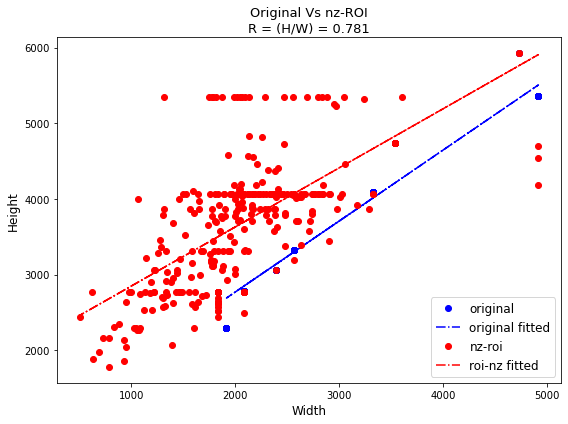

# Samples


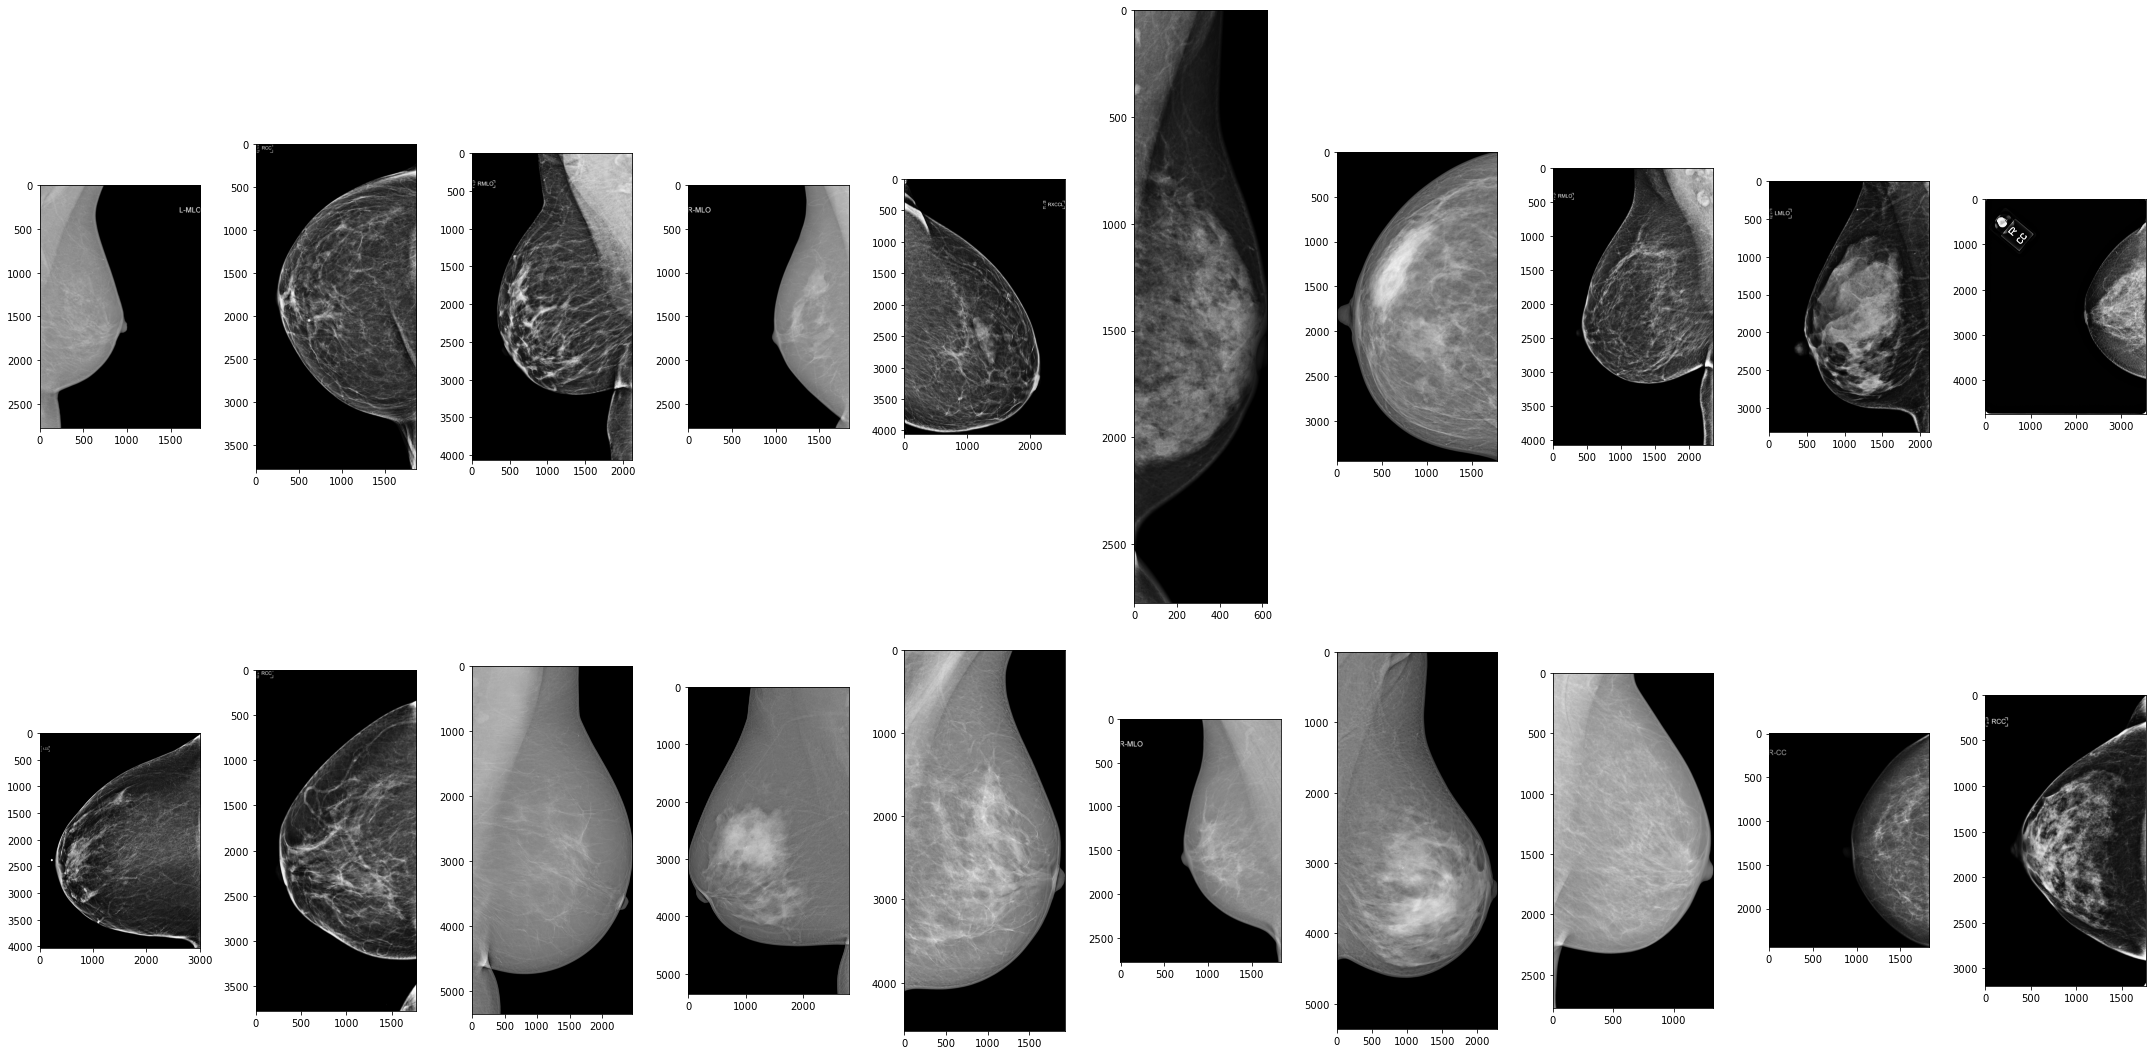

In [10]:
name = 'nz'
DATA[name] = {}
DATA[name]['df'], DATA[name]['time'] = check(eval(name), 'nz')
print('\n# Name: {} | Time: {:0.3f} s'.format(name, DATA[name]['time']))
plot_size(DATA[name]['df'], name)
print('# Samples')
show_roi(DATA[name]['df'])

# Binary Erode Largest Contour (BELC)

## code

In [11]:
def belc(img):
    """Binary Erode Largest Contour"""
    # binarize timage
    bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
    
    # remove straighnt line
#     bin_img = cv2.medianBlur(bin_img, 11)
    bin_img = cv2.erode(bin_img, np.ones((11, 11)))

    # create contours and keep only the largest one
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

   # Find ROI from largest contour
    xs = contour.squeeze()[:, 0]
    ys = contour.squeeze()[:, 1]
    roi =  img[np.min(ys):np.max(ys), np.min(xs):np.max(xs)]
    
    return roi

## test

100%|██████████| 300/300 [04:41<00:00,  1.06it/s]


# Name: belc | Time: 281.697 s


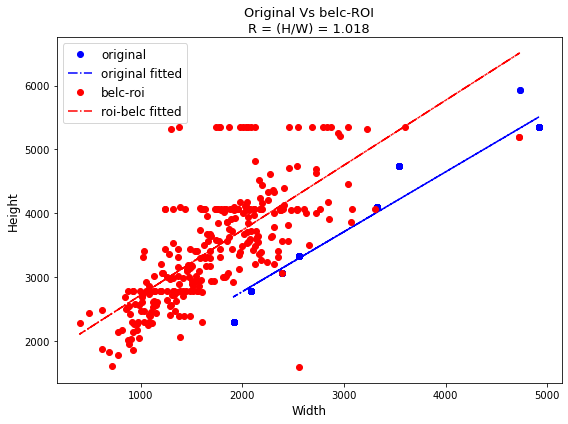

# Samples:


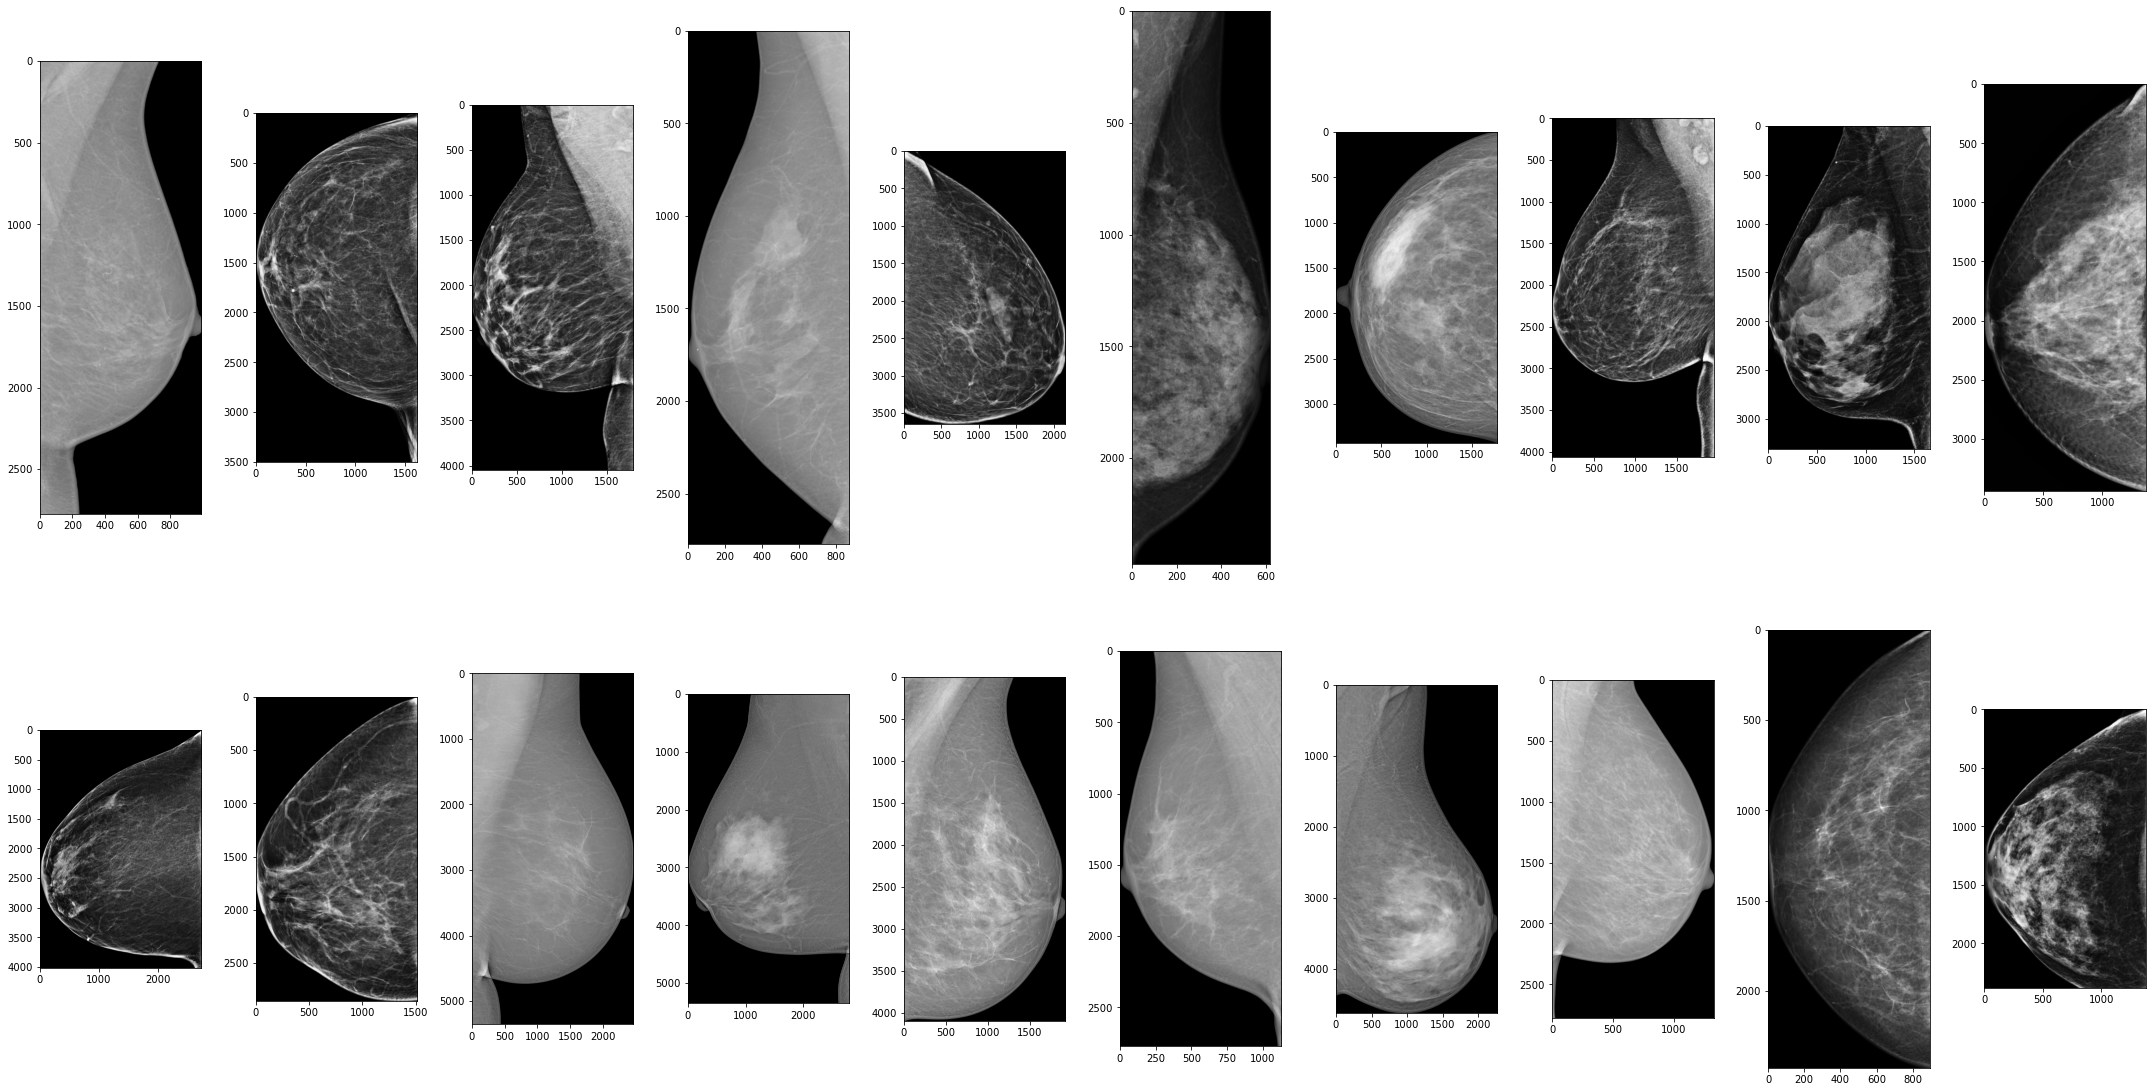

In [12]:
name = 'belc'
DATA[name] = {}
DATA[name]['df'], DATA[name]['time'] = check(eval(name), 'nz')
print('# Name: {} | Time: {:0.3f} s'.format(name, DATA[name]['time']))
plot_size(DATA[name]['df'], name)
print("# Samples:")
show_roi(DATA[name]['df'])

# AvgPixelValue (APV)

## code

In [13]:
def apv(img):
    """https://www.kaggle.com/code/michaelgartsbein/save-cropped-images"""
    av = np.mean(img, axis=0)
    mi = np.min(img, axis=0)
    ma = np.max(img, axis=0)
    img = img[:, (((av - mi) > 2) + ((av - ma) > 2))]
    return img

## test

100%|██████████| 300/300 [05:03<00:00,  1.01s/it]


# Name: apv | Time: 303.406 s


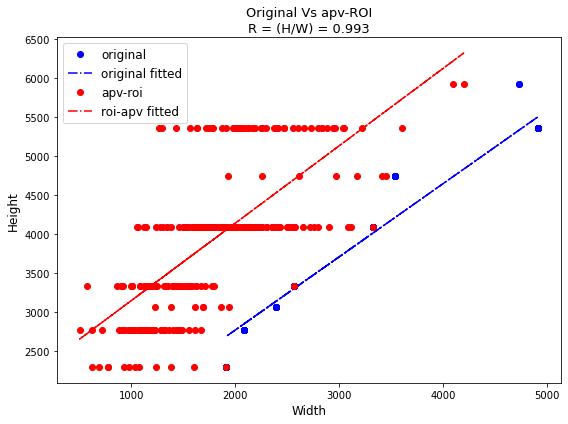

# Samples:


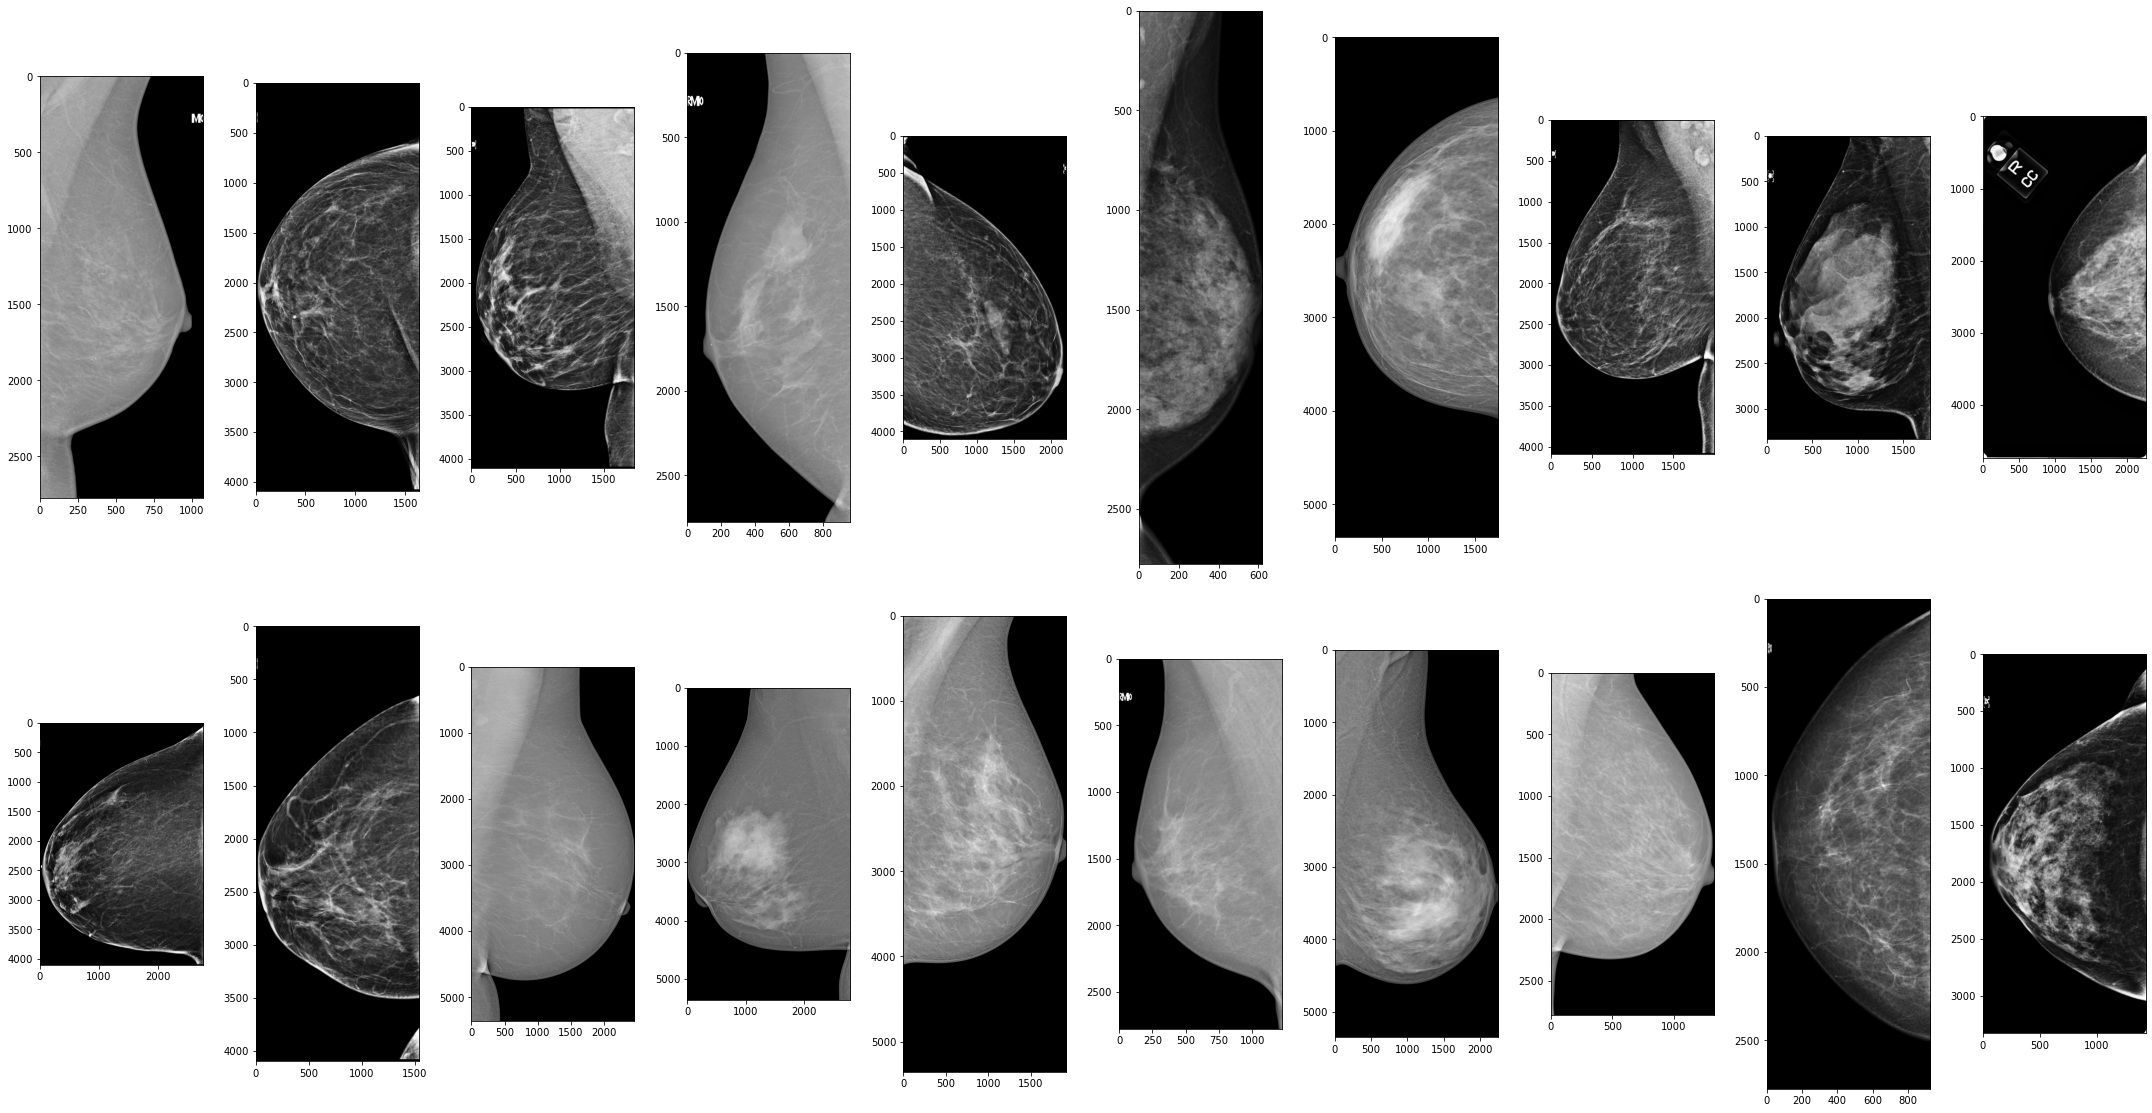

In [14]:
name = 'apv'
DATA[name] = {}
DATA[name]['df'], DATA[name]['time'] = check(eval(name), 'nz')
print('# Name: {} | Time: {:0.3f} s'.format(name, DATA[name]['time']))
plot_size(DATA[name]['df'], name)
print("# Samples:")
show_roi(DATA[name]['df'])

# Binary Masked Largest Contour (BMLC)

In [15]:
def bmlc(img):
    """https://www.kaggle.com/code/fabiendaniel/dicom-cropped-resized-png-jpg"""
    # Binarize the image
    bin_pixels = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
   
    # Make contours around the binarized image, keep only the largest contour
    contours, _ = cv2.findContours(bin_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # Create a mask from the largest contour
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
   
    # Use bitwise_and to get masked part of the original image
    out = cv2.bitwise_and(img, mask)
    
    # get bounding box of contour
    y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
    x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
    
    x1 = int(0.99 * x1)
    x2 = int(1.01 * x2)
    y1 = int(0.99 * y1)
    y2 = int(1.01 * y2)

    return out[y1:y2, x1:x2]

## test

100%|██████████| 300/300 [04:41<00:00,  1.07it/s]


# Name: bmlc | Time: 281.111 s


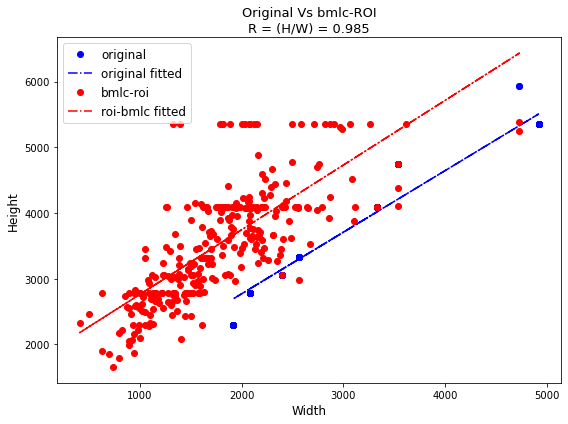

# Samples:


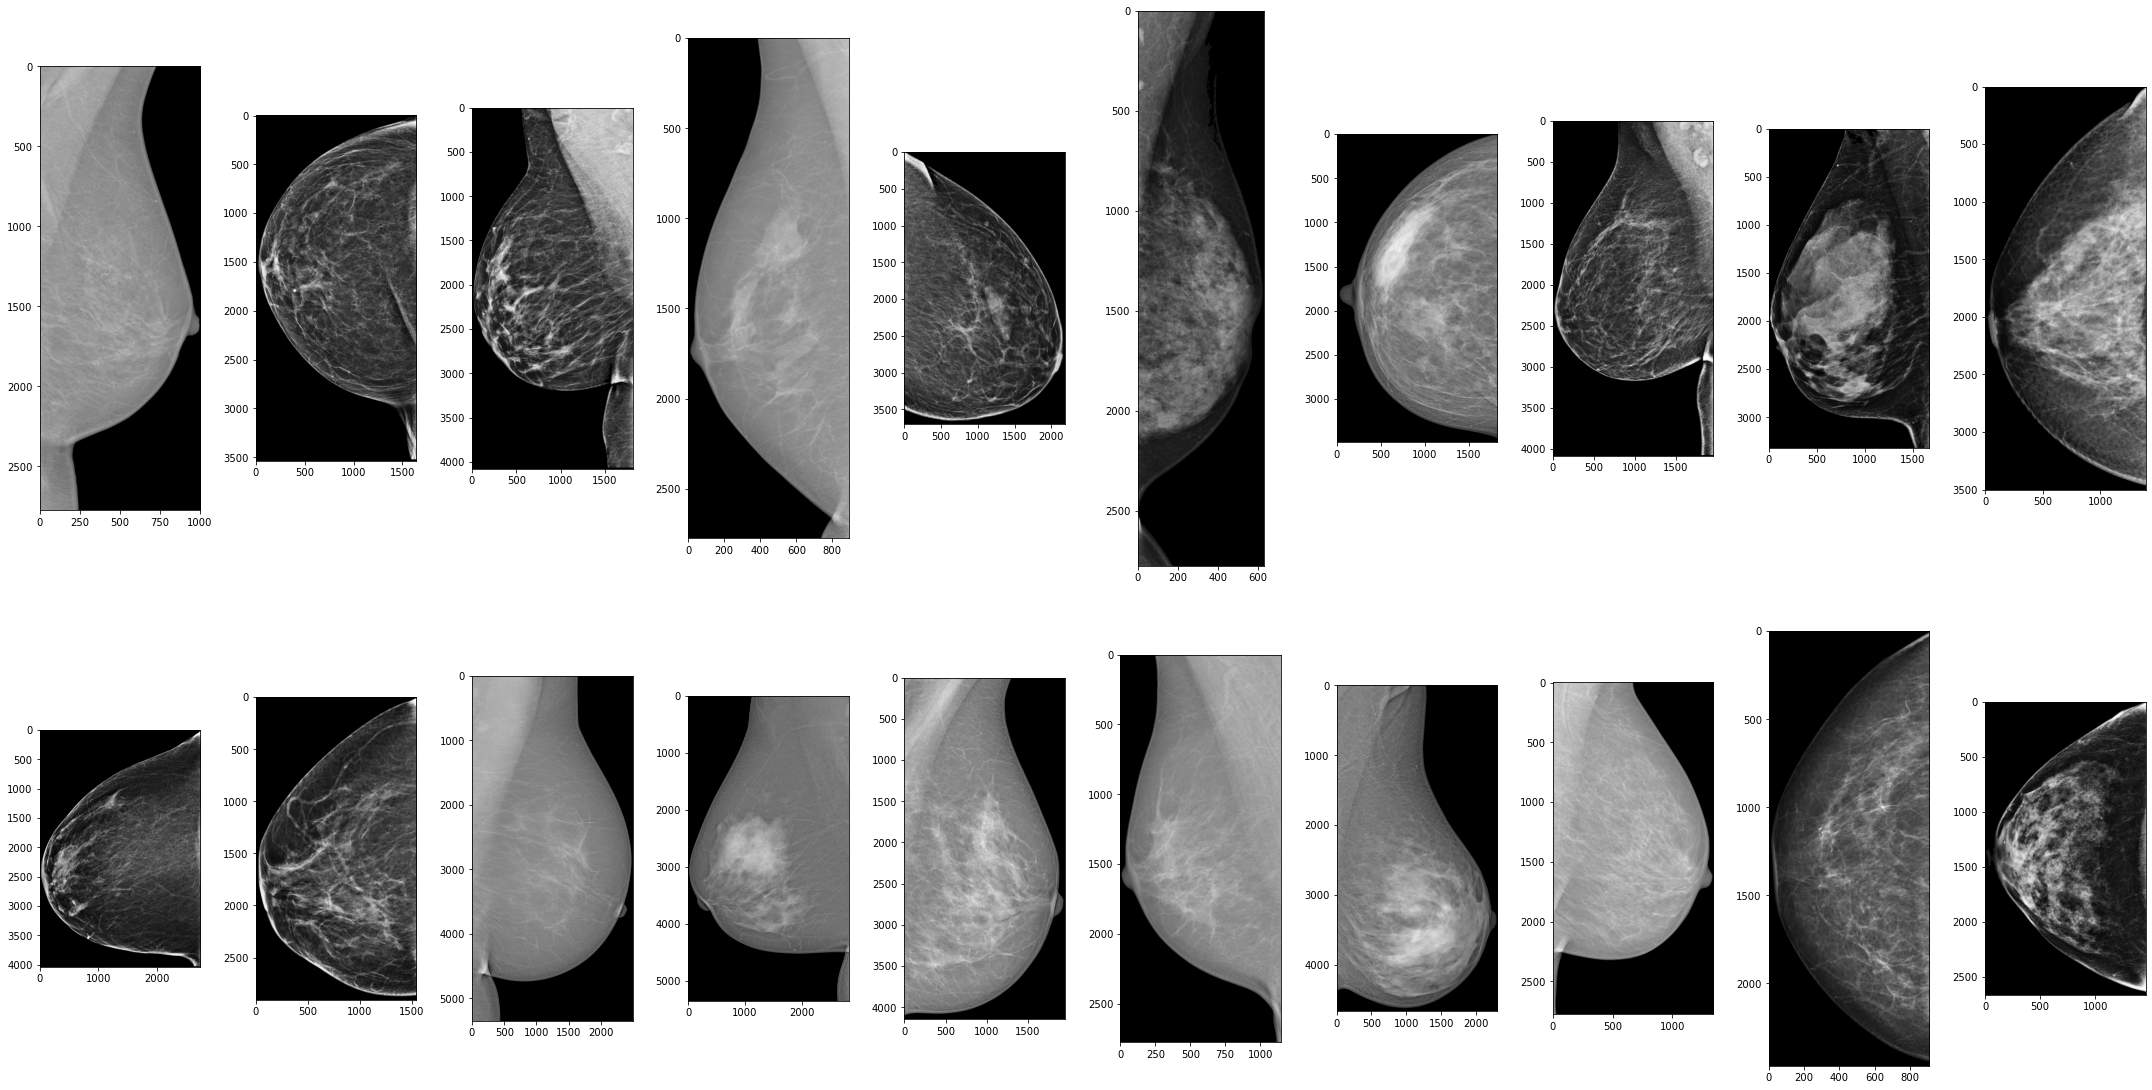

In [16]:
name = 'bmlc'
DATA[name] = {}
DATA[name]['df'], DATA[name]['time'] = check(eval(name), 'nz')
print('# Name: {} | Time: {:0.3f} s'.format(name, DATA[name]['time']))
plot_size(DATA[name]['df'], name)
print("# Samples:")
show_roi(DATA[name]['df'])

# Standard Deviation (STD)

## code

In [17]:
def std(img):
    """https://www.kaggle.com/code/salmanahmedtamu/faster-dicom-loading-and-cropping"""
    img = img[:,img.std(axis=0) > 20]
    img = img[img.std(axis=1) > 20, :]
    return img

## test

100%|██████████| 300/300 [05:39<00:00,  1.13s/it]


# Name: std | Time: 339.093 s


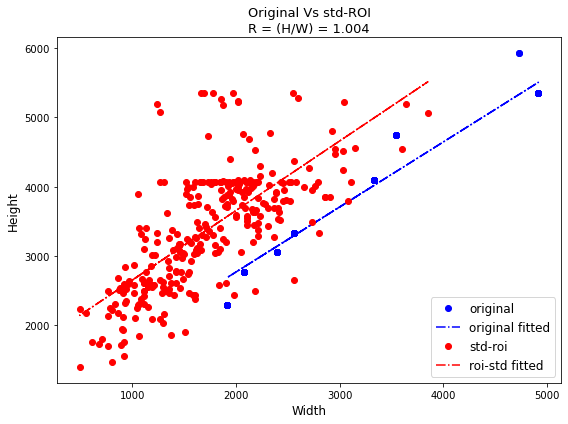

# Samples:


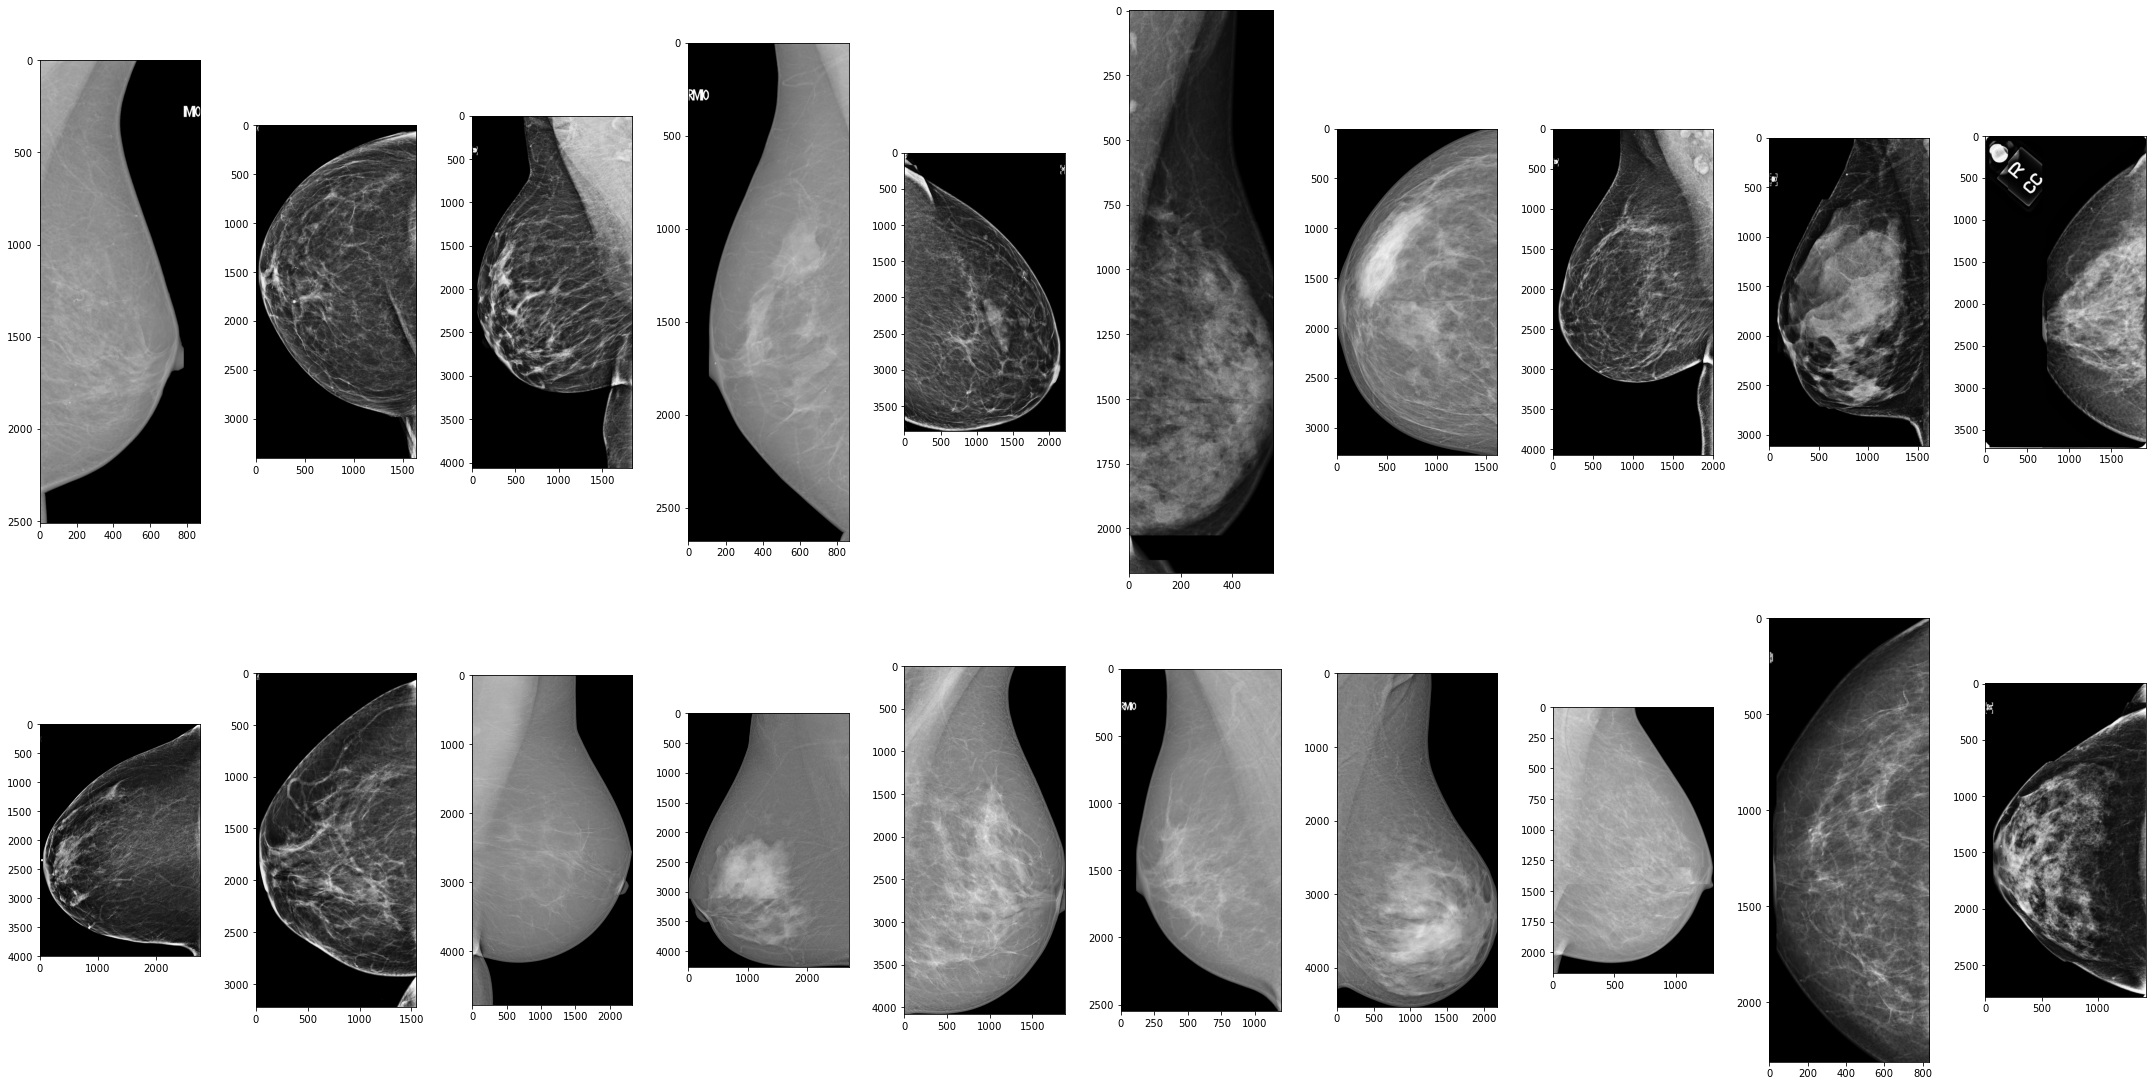

In [18]:
name = 'std'
DATA[name] = {}
DATA[name]['df'], DATA[name]['time'] = check(eval(name), 'nz')
print('# Name: {} | Time: {:0.3f} s'.format(name, DATA[name]['time']))
plot_size(DATA[name]['df'], name)
print("# Samples:")
show_roi(DATA[name]['df'])

# Blur Binary Largest Contour (BBLC)

## code

In [19]:
def bblc(img):
    """
    https://www.kaggle.com/code/snnclsr/roi-extraction-using-opencv
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return img[y:y+h, x:x+w]

## test

100%|██████████| 300/300 [04:56<00:00,  1.01it/s]


# Name: bblc | Time: 296.098 s


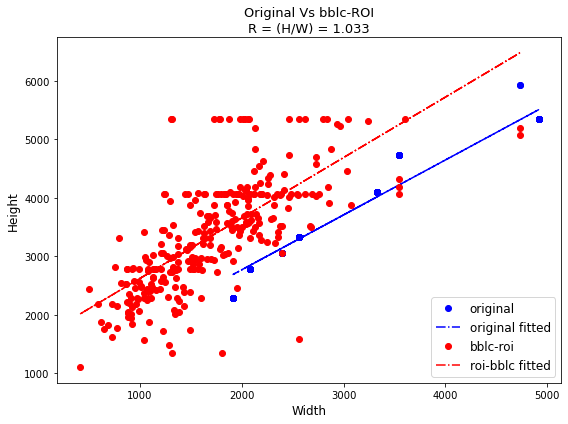

# Samples:


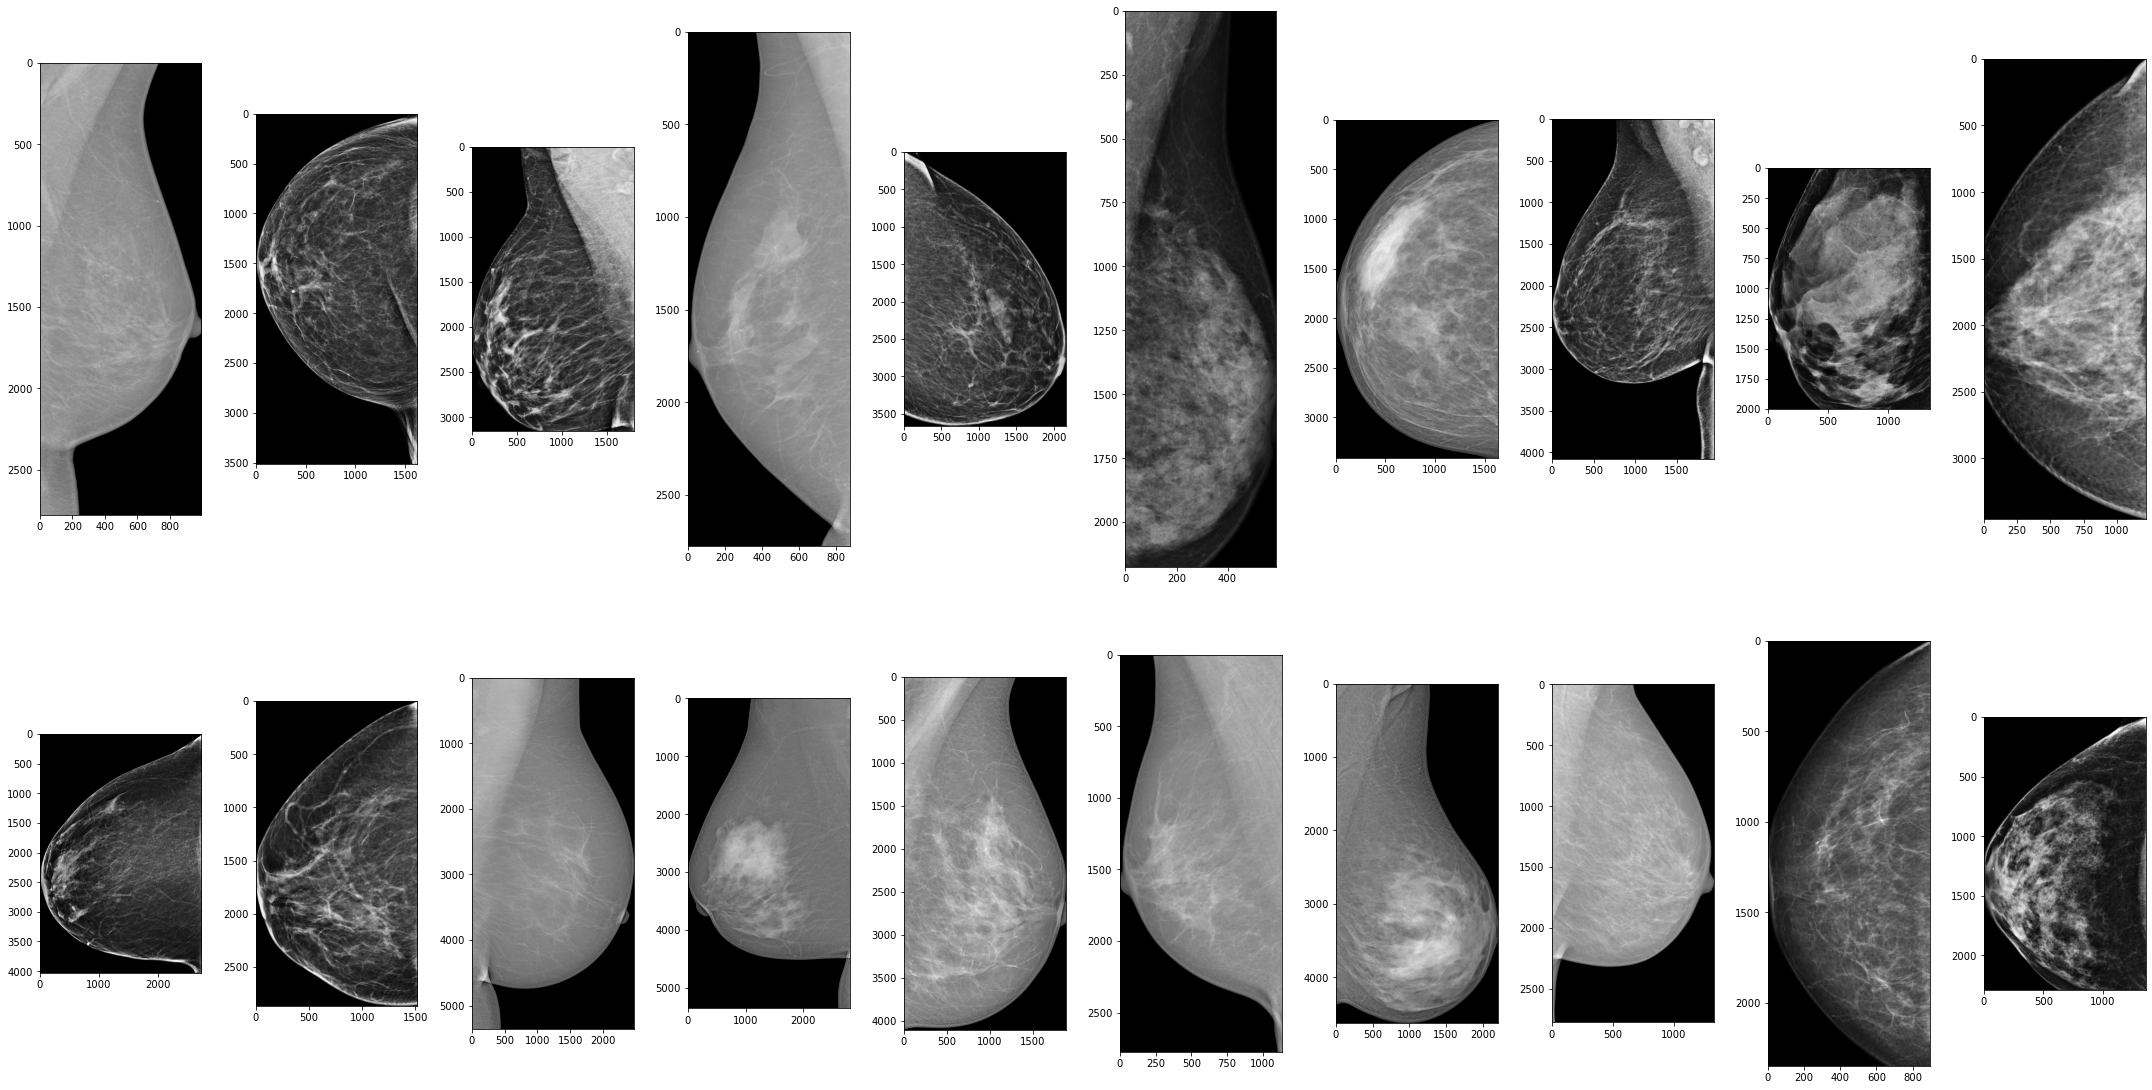

In [20]:
name = 'bblc'
DATA[name] = {}
DATA[name]['df'], DATA[name]['time'] = check(eval(name), 'nz')
print('# Name: {} | Time: {:0.3f} s'.format(name, DATA[name]['time']))
plot_size(DATA[name]['df'], name)
print("# Samples:")
show_roi(DATA[name]['df'])